<font size="8">Build an ANUGA Model (BAM) </font>

<font size="3">In this notebook, we will:

- set model configuration parameters

- download and preprocess elevation and landcover datasets

    
- Determine water body polygons


- Build the Digital Elevation Model



</font>

<font size="3">This could take some time, depending on model domain size and complexity of the water mask</font>


<font size=5 color='green'> If you are running in Google Colab, set the variable yes_colab = True.</font> <br>
<font size=5 color='blue'> If you are running on your own computer, set the variable yes_colab = False </font>


In [1]:
yes_colab = False


<font size=6> Step #1a: Set working directory <br> </font>



<font size=5 color='green'> If you are running in Google Colab, when you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>



In [2]:
import os
import sys
from pathlib import Path

your_path = Path(os.getcwd() + '/')
if yes_colab:
  where_to_mount = '/content/drive/'
  from google.colab import drive
  drive.mount(where_to_mount, force_remount=True)
  mounted_drive = where_to_mount + 'MyDrive/' 
  sys.path.append('/content/drive/MyDrive/installations')
else:
  mounted_drive = Path(os.path.abspath(os.path.join(your_path, os.pardir)))

print('Your working directory is %s' %(mounted_drive))

path_code = mounted_drive / "scripts"
path_templates = mounted_drive / 'templates'
path_configs = mounted_drive / 'configs'
path_ancillary = mounted_drive / 'ancillary'
path_examples = mounted_drive / 'examples'
sys.path.insert(1,str(path_code))


Your working directory is /Users/alchrist/Documents/GitHub/BAM


<font size=6> Step #1b: Install and import packages. <font> <br>

<font size=5 color='green'> If you are running in Google Colab, this cell should install all Python packages you need for each tutorial. </font> <br>
<font size=5 color='blue'> If you are running on your own computer, the packages were already installed when you installed the conda environment </font>


In [3]:
if yes_colab:
    if os.path.isdir(mounted_drive + '/komo_estuary_tutorial'):
        print('## Updating the local git repository \n')
        !rm -rf {mounted_drive}/komo_estuary_tutorial/

    print('## Pulling the git repository with files for the tutorial\n')
    !git clone https://github.com/achri19/komo_estuary_tutorial.git

    print('\n## Installing the Python packages needed for these tutorials\n')
    !/bin/bash $mounted_drive/komo_estuary_tutorial/install_packages_colab_debug.sh


In [4]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rtree
#import pygeos
#import pyTMD


In [5]:
from main_tools import (build_directory,
                       get_extent_parameters,
                       setup_AOI_files, 
                       make_polygons,
                       make_channel_networks,
                       make_model_foundation, 
                       set_boundary_conditions, 
                       make_watermask,
                       more_opening)


/users/alchrist/documents/github/BAM/scripts/orinoco_tools.py:42: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/users/alchrist/documents/github/BAM/scripts/orinoco_tools.py:43: UserWarning: UserWarning
  warnings.warn('UserWarning')


<font size=6> Step #1c: Unzip example files in Komo.zip <font> 




In [6]:
import zipfile
with zipfile.ZipFile(path_examples / "komo_starter.zip", 'r') as zip_ref:
    zip_ref.extractall(path_examples)
    

<font size=3> We will access data files stored on a shared Google Drive. You will also need to save files to your own Google Drive.<font>



<font size=6, color ='black' > Step #2: Set the AOI and working directory  </font>


AOI should match the name of the folder where files will be saved

In [7]:
AOI = 'komo'

Path((path_examples / AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)
working_path = Path(working_path)
print(working_path)





Study area is komo
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/alchrist/Documents/GitHub/BAM/notebooks/examples/komo
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 

<font size='6' > Step #3: Configuration Parameters </font>


In [8]:
try:
    parameters = pd.read_csv(folders[6] / ('config_%s.csv' %(AOI)))
except:    
    parameters = pd.DataFrame()
    parameters['AOI'] = [AOI]
    parameters['RiverOceanBoundary'] = '1260'
    parameters['Discharge'] = '426'

    #Method parameters:
    parameters['LandcoverMethod'] = 'WorldCover'
    parameters['LandElevMethod'] = 'GLO30'
    parameters['OceanElevMethod'] = 'GEBCO'
    parameters['LowerRiverElevMethod'] = 'plane'
    parameters['UpperRiverElevMethod'] = 'wdpower'
    parameters['WetlandElevMethod'] = 'constant_0.5'
    parameters['LakeElevMethod'] = 'constant_1'
    parameters['ManningLUT'] = 'default'
    parameters['WetlandClass'] = '90'

    #Coefficients for determining bathymetry:
    parameters['WD_POWERA_upper'] = '0.0606'
    parameters['WD_POWERB_upper'] = '0.7732'

    #Max thresholds:
    parameters['MaxOceanDepth'] = '-300'
    parameters['MaxNearshoreDepth'] = '-300'
    parameters['MaxRiverDepth'] = '-300'
    parameters['MaxRiverWidth'] = '756'



In [9]:
ref_10m,parameters = get_extent_parameters(path_ancillary,AOI,folders,res,parameters)





##############################################################################################
##############################[Step 1b][GetExtentParameters]##################################
##############################################################################################

##################### AOI extent is set by: komo_input.shp
The input shapefile is not in the correction projection (EPSG 4326), reprojecting to EPSG 4326

[Step 2][Setup_AOI_Files][Determine EPSG code and UTM zone] .......

##################### ANUGA Models must be in UTM
##################### UTM Zone: 32n
##################### EPSG: 32232 

[Step 2][Setup_AOI_Files][Extending AOI by 1000m] .......


[Step 2][Setup_AOI_Files][Setting up AOI extent] .......

##################### AOI bounds are : 501790, -2260, 610150, 64700
##################### Approximate area of AOI extent is 7256.0 km^2

[Step 2][Setup_AOI_Files][Downloading GEBCO Dataset as reference for projection, resolution, etc] .......


[S

Text(0.5, 1.0, 'GEBCO Bathymetry resampled to 10m resolution')

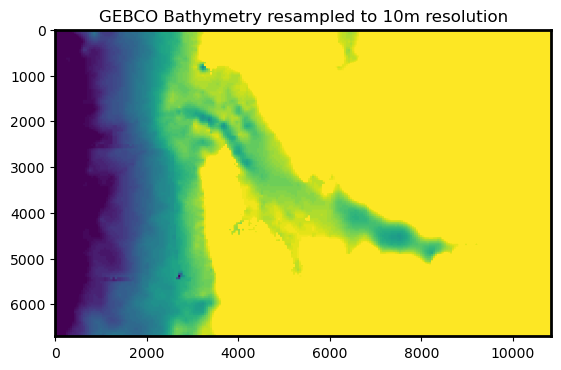

In [10]:
plt.imshow(ref_10m.read(1),vmin=-50,vmax=0)
plt.title('GEBCO Bathymetry resampled to 10m resolution')

<font size='5' color = 'red' > The parameters were saved to a configuration file, we open that here </font>


In [11]:
parameters = pd.read_csv(folders[2] / ('%s_Configuration.csv' %(AOI)))
print(parameters.iloc[0] )

Unnamed: 0                         0
AOI                             komo
RiverOceanBoundary              1260
Discharge                        426
LandcoverMethod           WorldCover
LandElevMethod                 GLO30
OceanElevMethod                GEBCO
LowerRiverElevMethod           plane
UpperRiverElevMethod         wdpower
WetlandElevMethod       constant_0.5
LakeElevMethod            constant_1
ManningLUT                   default
WetlandClass                      90
WD_POWERA_upper               0.0606
WD_POWERB_upper               0.7732
MaxOceanDepth                   -300
MaxNearshoreDepth               -300
MaxRiverDepth                   -300
MaxRiverWidth                    756
ulx                           501794
lry                            -2259
lrx                           610154
uly                            64701
EPSG                           32232
Name: 0, dtype: object


<font size='6' > Step #4: Download datasets </font>
<br> Download GEBCO, GLO30, World Cover, and Global Mangrove Maps for the area</font>

In [12]:
ref = setup_AOI_files(your_path,
                    AOI,
                    folders,
                    res,
                    parameters)





##############################################################################################
#################################[Step 2][Setup_AOI_Files]####################################
##############################################################################################

The input shapefile is not in the correction projection (EPSG 4326), reprojecting to EPSG 4326
##################### Reference raster is komo_GEBCO_30.tif
##################### This profile will be used for all future warping
##################### Resolution is 30m

[Step 2][Setup_AOI_Files][Compiling OCEAN elevation dataset] .......

##################### Ocean elevation set with:  GEBCO

[Step 2][Setup_AOI_Files][Compiling LAND elevation dataset] .......

##################### Land elevation set with: GLO30

[Step 2][Setup_AOI_Files][Compiling Landcover Classification Maps] .......

##################### Landcover types based on: WorldCover

[Step 2][Setup_AOI_Files][Loading Global Mangrove Watch ] .

<font size='5' color = 'red' > The EPSG coordinate reference system must be is in UTM </font>


In [13]:
EPSG = parameters['EPSG'][0]
ulx = parameters['ulx'][0]
uly = parameters['uly'][0]
lrx = parameters['lrx'][0]
lry = parameters['lry'][0]


Text(0.5, 1.0, 'WorldCover Landcover Map')

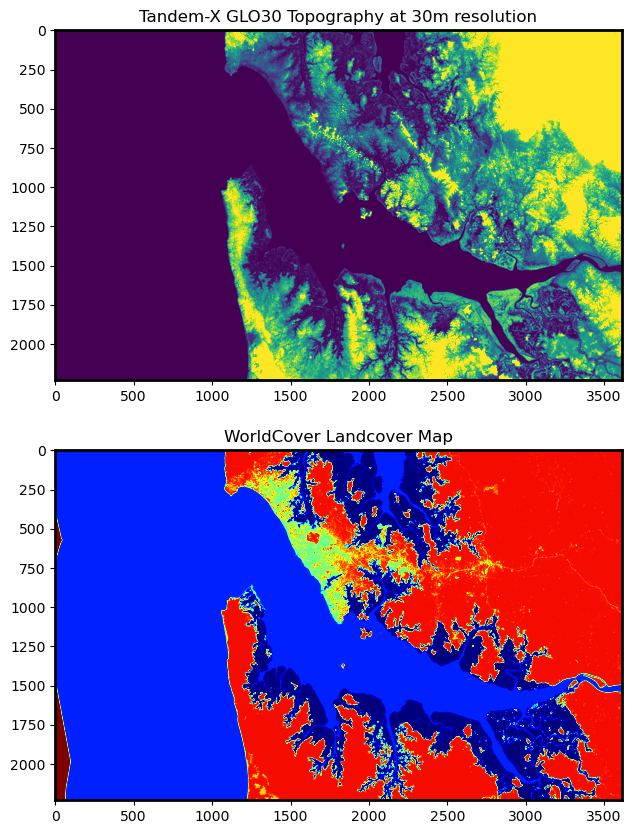

In [14]:
#ref = rasterio.open('%s/%s_GEBCO_%s.tif' %(folders[8],AOI,res))
glo30 = rasterio.open(folders[8] / ('%s_GLO30_topo_%s.tif' %(AOI,res)))
landcover = rasterio.open(folders[8] / ('%s_WorldCover_%s.tif' %(AOI,res)))


fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(10,10))
ax1.imshow(glo30.read(1),vmin=0,vmax=50,cmap = 'viridis')
ax1.set_title('Tandem-X GLO30 Topography at 30m resolution')

ax2.imshow(landcover.read(1),cmap='jet_r')
ax2.set_title('WorldCover Landcover Map')


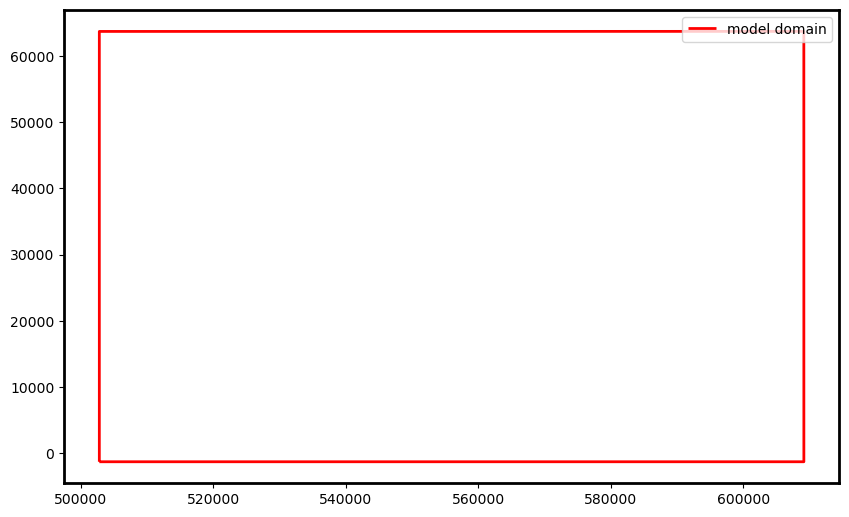

In [15]:
model_domain = gpd.read_file(folders[7] / ('%s_modeldomain.shp' %(AOI)))

fig,ax = plt.subplots(figsize=(10,10))
model_domain.geometry.boundary.plot(color=None,edgecolor='red',linewidth = 2,ax=ax,label = 'model domain') #Use your second dataframe

plt.legend()

<font size='6' > Step #4: Clean the water mask </font> <br>
Clean, filter, smooth the water mask you made in the previous notebook </font>



In [16]:
#ref_10m = rasterio.open('%s/%s_GEBCO_10.tif' %(folders[8],AOI))
watermaskname = make_watermask(path_ancillary, 
                               AOI,
                               folders,
                               parameters,
                               ref_10m,
                               False, 
                               os.path.isfile('%s_watermask_%s.tif' %(folders[8]/AOI,res)))
how_much_opening = 3
if os.path.isfile('%s_watermask_%s.tif' %(folders[8]/AOI,30)) == False:
    more_opening(AOI,folders,watermaskname,how_much_opening,ref_10m,parameters)





##############################################################################################
#################################[Step 3a][Make_Watermask]####################################
##############################################################################################


[Step 2][Setup_AOI_Files][Compiling Water Masks] .......


[Step 3A][Make_Watermask] Skip .........



In [17]:
print(watermaskname)
if res != 10:
    os.system('gdalwarp -overwrite -tr %s %s %s %s '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8]/ ("%s_watermask_10.tif " %(AOI)),folders[8] / ("%s_watermask_%s.tif" %(AOI,res)),ulx,lry,lrx,uly))
    os.system('gdalwarp -overwrite -tr %s %s %s %s '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8] / ("%s_landmask_10.tif" %(AOI)),folders[8] / ("%s_landmask_%s.tif" %(AOI,res)),ulx,lry,lrx,uly))


komo_ndvimin_ndwimin_clustered_finalwatermask


(1500.0, 2000.0, 2000.0, 1500.0)

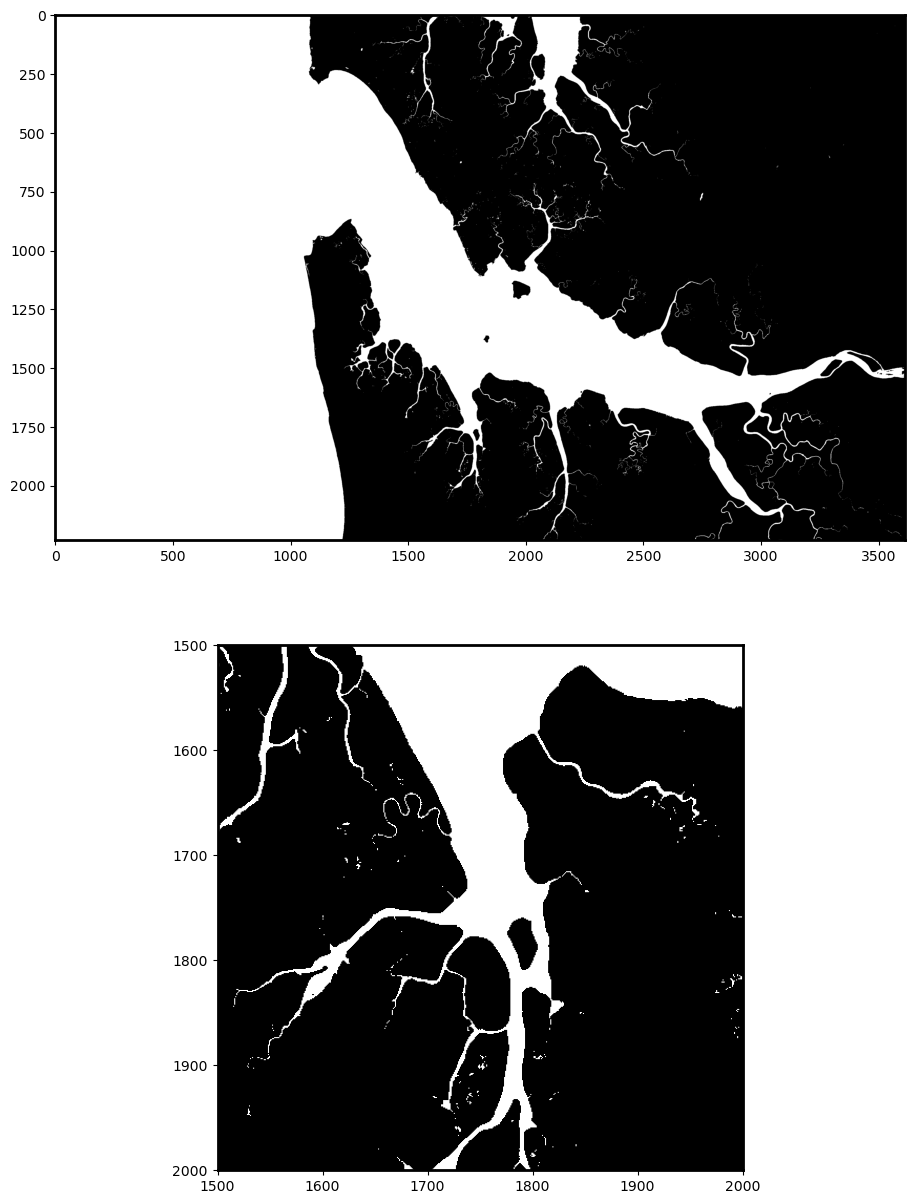

In [18]:
watermask = rasterio.open(folders[8] / ('%s_watermask_%s.tif' %(AOI,res))).read(1)

fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(15,15))
ax1.imshow(watermask,'gray')

ax2.imshow(watermask,'gray')
ax2.axis([1500,2000, 2000,1500])

<font size='6' > Step #5: Make polygons of each land cover type <br> </font>
Ocean, lake, river, land


In [19]:
make_polygons(AOI,
            folders,
            parameters,
            ref,
            watermaskname,
            path_templates,
            os.path.isfile('%s_lands_%s.tif' %(folders[8]/AOI,res)))





##############################################################################################
################################[Step 4][Make_Polygons]######################################
##############################################################################################


[Step 4][Make_Polygons][Open land/water mask] .......

##################### Water delineated with komo_ndvimin_ndwimin_clustered_finalwatermask_30

[Step 4][Make_Polygons] SKIP.......



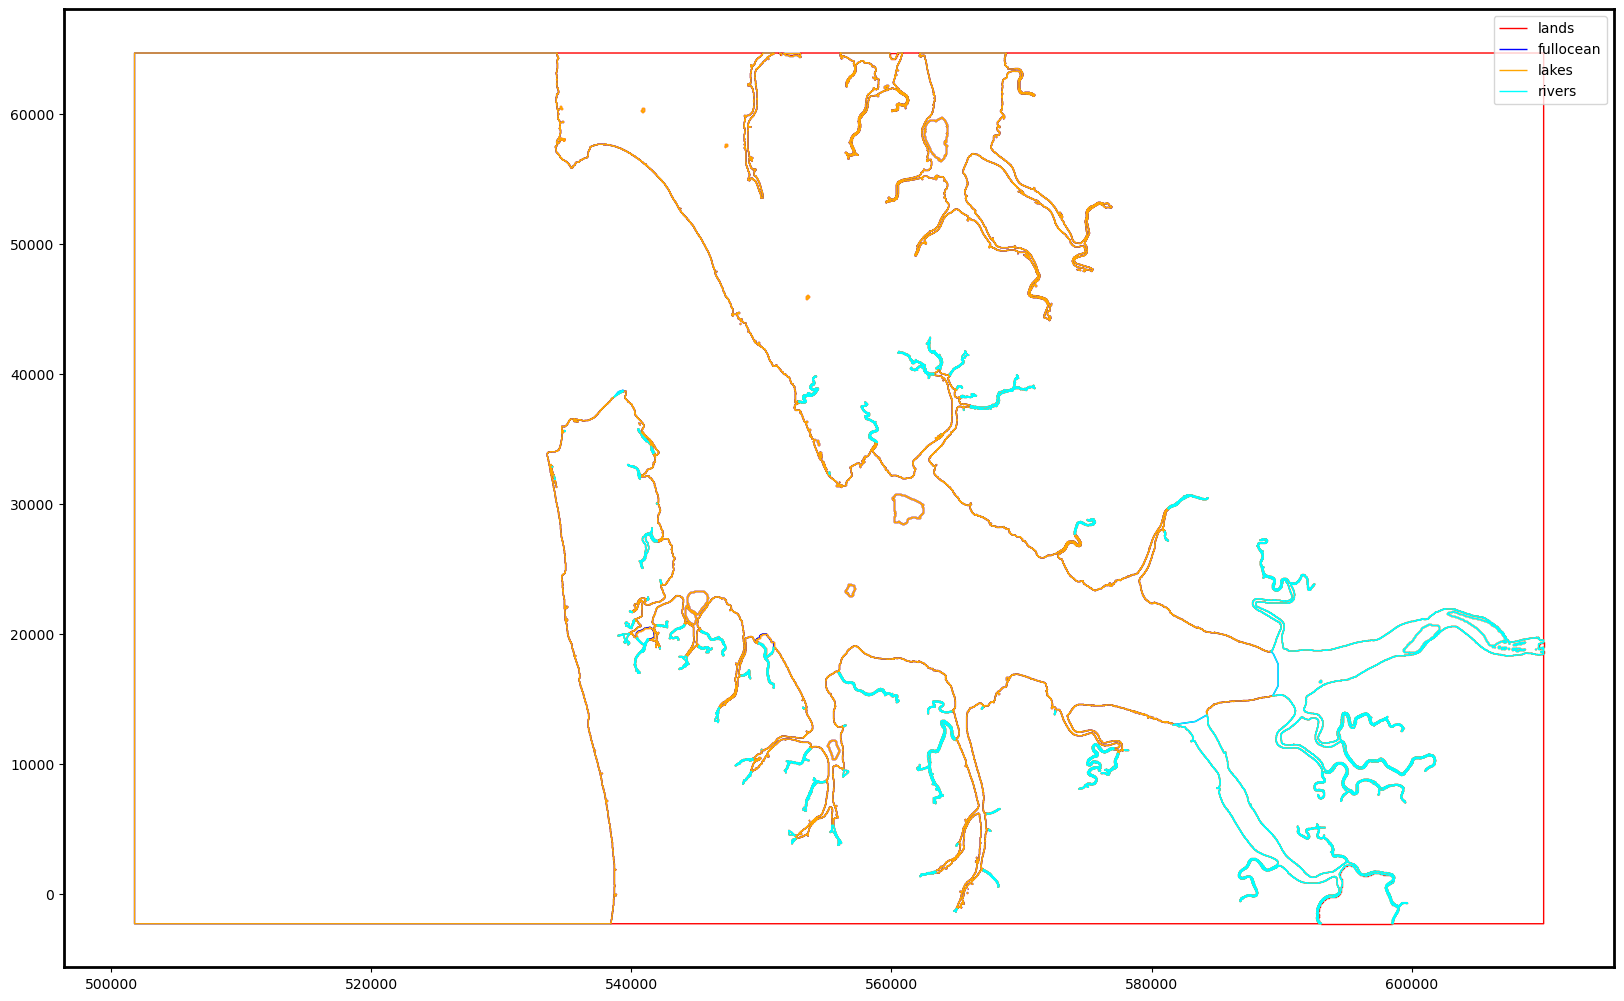

In [20]:
fix,ax = plt.subplots(figsize=(20,20))

colors = ['red','blue','orange','cyan','green']
polys = ['lands','fullocean','lakes','rivers']
i=0
for poly in polys:
    tmp = gpd.read_file([os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(folders[7])
            for f in fnmatch.filter(files,'*%s*.shp' %(poly))][0])
    tmp.geometry.boundary.plot(color=colors[i], edgecolor=colors[i],linewidth = 1,ax=ax,label = poly) #Use your second dataframe
    i=i+1
plt.legend()


<font size='6' > Step #6: Using Orinoco, get distance and width of the river networks</font>


In [21]:
segment_width = 150
pixel_step = int(round(segment_width/res))
try:
  distance = gdal.Open('%s_distance_%s.tif' %(folders[8] / AOI,res)).ReadAsArray()
  widths = gdal.Open('%s_widths_%sx%s.tif' %(folders[8] / AOI,res,pixel_step)).ReadAsArray()
except:
  distance,widths = make_channel_networks(folders,
                                      AOI,
                                      ref,
                                      parameters,
                                      pixel_step,False)


<font size='6' > Step #7: Make the Digital Elevation Model </font>


In [22]:
elevation,elev_name = make_model_foundation(mounted_drive,
                                                parameters,
                                                AOI,
                                                folders,
                                                ref,
                                                distance,
                                                widths,
                                                watermask,pixel_step,mounted_drive)





##############################################################################################
###############################[Step 6][Make_Model_Foundation]################################
##############################################################################################


[Step 6][Make_Model_Foundation][Determine all methods for calculating elevation for each land/water type] .......

##################### Method for land = GLO30
##################### Method for ocean = GEBCO
##################### Method for lower river reaches = plane
##################### Method for upper river reaches = wdpower
##################### Method for lakes = constant_1
##################### Method for wetlands = constant_0.5
##################### Max Depth for Rivers = -300
##################### Max Depth for Oceans = -300
##################### Max Depth for Nearshore = -300
##################### Boundary between Upper and Lower river reaches =  1260m
/Users/alchrist/Documents/GitHub/BAM/n

<font size=5 color='green'> We will use the elevation file in later notebooks. </font>

In [25]:
print(elev_name)


Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1m_30


<font size='6' > Step #6: Clean up temporary files </font> <br>


In [26]:
cleanup = False 
if cleanup == True:
    print('Cleaning up temporary files')
    try:shutil.rmtree(folders[1])
    except:''


<font size=5 color='red'> Done building DEM and other ancillary files. Move on to the next notebook 3_GetBoundaries.ipynb </font>
